# Predicting NHL Regular Season Wins: Exploratory Data Analysis (2007–2023)

---

## Introduction

This exploratory data analysis (EDA) investigates NHL team metrics from **2007 to 2023** to uncover key predictors of regular season wins. The dataset reflects all available data, including metrics like CORSI and Fenwick, faceoff win percentage, etc.

## Hypothesis

### Null Hypothesis (H₀)
There is no predictive relationship between NHL team metrics and the number of team wins during the regular season.

### Alternative Hypothesis (H₁)
There is a predictive relationship between NHL team metrics and team wins, meaning that team metrics have a significant impact on predicting the number of wins a team could achieve during the regular season.

## Data Source and Methodology

- **Data Sources:**  
  The dataset is sourced from the [NHL API](https://github.com/Zmalski/NHL-API-Reference) and [www.naturalstattrick.com](https://www.naturalstattrick.com/glossary.php?teams#), which provides enriched and accurate raw NHL season data per team. Definitions and documentation of these metrics are available [HERE](https://nhl-db-documentation.netlify.app/#!/overview).
  
- **Methodology:**  
  This analysis employs **Multiple Linear Regression** to assess the relationship between team metrics and their influence on regular season wins.

---

## Practical Applications

This analysis is particularly relevant for **junior hockey coaches** seeking data-driven strategies to enhance team performance. It offers:

- **Actionable Insights:** Highlights critical metrics for improving team success.
- **Strategic Guidance:** Provides a framework for informed decision-making and resource allocation to optimize regular season outcomes.

Table of Contents
=================

1. [Data Preprocessing](#Data-Preprocessing)
    - [Feature Discussion](#Feature-Discussion)
2. [Univariate Analysis](#Univariate-Analysis)
    - [Comments on Feature Distributions and Selection](#Comments-on-Feature-Distributions-and-Selection)
    - [Comments on Feature frequencies and Selection](#Comments-on-Feature-frequencies-and-Selection)
    - [Exploration on the Target Variable: Wins](#Exploration-on-the-Target-Variable:-Wins)
3. [Bivariate Analysis](#Bivariate-Analysis)

## Data Preprocessing

---

In [2]:
import os 
import sys
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from scipy.stats.mstats import normaltest

import warnings
warnings.filterwarnings('ignore')

# Get the current working directory (the directory of the running script)
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'Regression_Functions')))
from Preprocessing_Functions import Preprocessing

In [71]:
data_path = os.path.abspath(
    os.path.join(
        current_dir,
        "..",
        "..",
        r"Dashboard\Dashboard_Data_In_Use\analysis_view.xlsx",
    )
)

df = pd.read_excel(data_path)

df = df[(df["start_year"] >= 2007) & (df["start_year"] < 2024)].reset_index(
    drop=True
)
df = df[df['game_type']=='Regular Season'].reset_index(drop=True)

df['time_on_ice'] = df['time_on_ice'].str.replace(':', '.', 1).str[:-3]
df['time_on_ice'] = df['time_on_ice'].astype(float)

# create a blocked shots feature
df['blocked_shots'] = df['corsi_against'] - df['fenwick_against']
df['shots_blocked'] = df['corsi_for'] - df['fenwick_for']

per_60_minutes_columns = [
    'blocked_shots',
    'shots_blocked',
    "corsi_for",
    "corsi_against",
    "fenwick_for",
    "fenwick_against",
    "shots_for",
    "shots_against",
    "goals_for",
    "goals_against",
    "expected_goals_for",
    "expected_goals_against",
    "scoring_chances_for",
    "scoring_chances_against",
    "scoring_chances_shots_for",
    "scoring_chances_shots_against",
    "scoring_chances_goals_for",
    "scoring_chances_goals_against",
    "high_danger_chances_for",
    "high_danger_chances_against",
    "high_danger_shots_for",
    "high_danger_shots_against",
    "high_danger_goals_for",
    "high_danger_goals_against",
    "medium_danger_chances_for",
    "medium_danger_chances_against",
    "medium_danger_shots_for",
    "medium_danger_shots_against",
    "medium_danger_goals_for",
    "medium_danger_goals_against",
    "low_danger_chances_for",
    "low_danger_chances_against",
    "low_danger_shots_for",
    "low_danger_shots_against",
    "low_danger_goals_for",
    "low_danger_goals_against",
]

for col in per_60_minutes_columns:
    df[col+"_per_60_minutes"]=df[col] * 60 / df['time_on_ice']

column_to_move = "wins"
columns = [column_to_move] + [col for col in df.columns if col!=column_to_move]
df = df[columns]

df = df.loc[df['wins']<62] # Remove outliers

df = df[[
    'wins',
    'start_year',
    'game_type',
    'games_played',
    'faceoff_win_pct',
    'penalty_kill_net_pct',
    'power_play_net_pct',
    'blocked_shots',
    'shots_blocked',
    'corsi_for',
    'corsi_against',
    'fenwick_for',
    'fenwick_against',
    'high_danger_chances_for',
    'high_danger_chances_against',
    'high_danger_shots_for',
    'high_danger_shots_against',
    'save_pct',
]]

df.info(verbose=True, show_counts=True)
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 518 entries, 0 to 519
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   wins                         518 non-null    int64  
 1   start_year                   518 non-null    int64  
 2   game_type                    518 non-null    object 
 3   games_played                 518 non-null    int64  
 4   faceoff_win_pct              518 non-null    float64
 5   penalty_kill_net_pct         518 non-null    float64
 6   power_play_net_pct           518 non-null    float64
 7   blocked_shots                518 non-null    int64  
 8   shots_blocked                518 non-null    int64  
 9   corsi_for                    518 non-null    int64  
 10  corsi_against                518 non-null    int64  
 11  fenwick_for                  518 non-null    int64  
 12  fenwick_against              518 non-null    int64  
 13  high_danger_chances_for  

,wins,start_year,game_type,games_played,faceoff_win_pct,penalty_kill_net_pct,power_play_net_pct,blocked_shots,shots_blocked,corsi_for,corsi_against,fenwick_for,fenwick_against,high_danger_chances_for,high_danger_chances_against,high_danger_shots_for,high_danger_shots_against,save_pct
0,46,2007,Regular Season,82,0.503966,0.847133,0.134375,641,738,3095,2818,2357,2177,561,531,439,440,0.9247
1,35,2007,Regular Season,82,0.510504,0.845333,0.100000,809,847,3279,3231,2432,2422,667,645,513,485,0.9240
2,42,2007,Regular Season,82,0.522979,0.857142,0.148648,718,744,3311,2797,2567,2079,665,635,504,495,0.9262


### Feature Discussion

#### Additional Features in the dataframe
In the data frame, '**`blocked_shots`** and **`shots_blocked`** were drived by subtracting Fenwick (goals, shots on net, and misses) stats from Corsi (goals, shots on net, misses, and blocks) stats. 

Additionally, features were generated by manipulating cumulative metrics such as **`goals_for`** and **`goals_against`** with **`time_on_ice`**. These new features introduce an **efficiency aspect**, aiming to capture additional variability in their relationship with **`wins`**. By analyzing these cumulative metrics, the model attempts to better understand how team performance metrics contribute to overall success. The efficiency metrics are calculated as:

$$
\text{manipulated feature} = \left( \frac{\text{feature}}{60} \right) \times \text{time on ice}
$$


---

#### Scoring Chances Context
The data, through naturalstatrick.com add many features such as high, medium, and low danger goals and scoring chances. To further enhance the understanding of scoring opportunities, **scoring chances** are defined based on shot attempts (CORSI - all shots, blocked shots, and misses) taken in the offensive zone. These attempts are assigned values depending on the specific region of the offensive zone, as shown in the diagram below:

![Scoring Chances Zones](Socring_chances.JPG)

Attempts from the yellow areas are assigned a value of 1, attempts from the red areas are assigned a value of 2, and attempts in the green area are assigned a value of 3.

Add 1 to this value if the attempt is considered a rush shot or a rebound. A rebound is any attempt made within 3 seconds of another blocked, missed or saved attempt without a stoppage in play in between. A rush shot is any attempt within 4 seconds of any event in the neutral or defensive zone without a stoppage in play in between (originally defined by David Johnson on the now-offline Hockey Analysis, and modified to 4 seconds by War-on-Ice).

Decrease this value by 1 if it was a blocked shot.

Any attempt with a score of 2 or higher is considered a scoring chance.

These definitions were originally outlined by **David Johnson** on the now-offline Hockey Analysis and later adapted by **War-on-Ice**. For context **David Johnson** and **war on ice** contributions helped shape how hockey is analyzed today. Many of the concepts and metrics originally discussed **David Johnson** and **war on ice** are now mainstream in hockey analytics and used in decision-making by NHL teams, broadcasters, and fans. 

---

### Key Takeaway
By introducing cumulative metrics, leveraging refined definitions of scoring chances, and the standard hockey metrics, the analysis captures both team efficiency and high-impact scoring opportunities. These features aim to enhance the model’s ability to explain variability in **wins** and improve its predictive accuracy.


## Univariate Analysis 
---

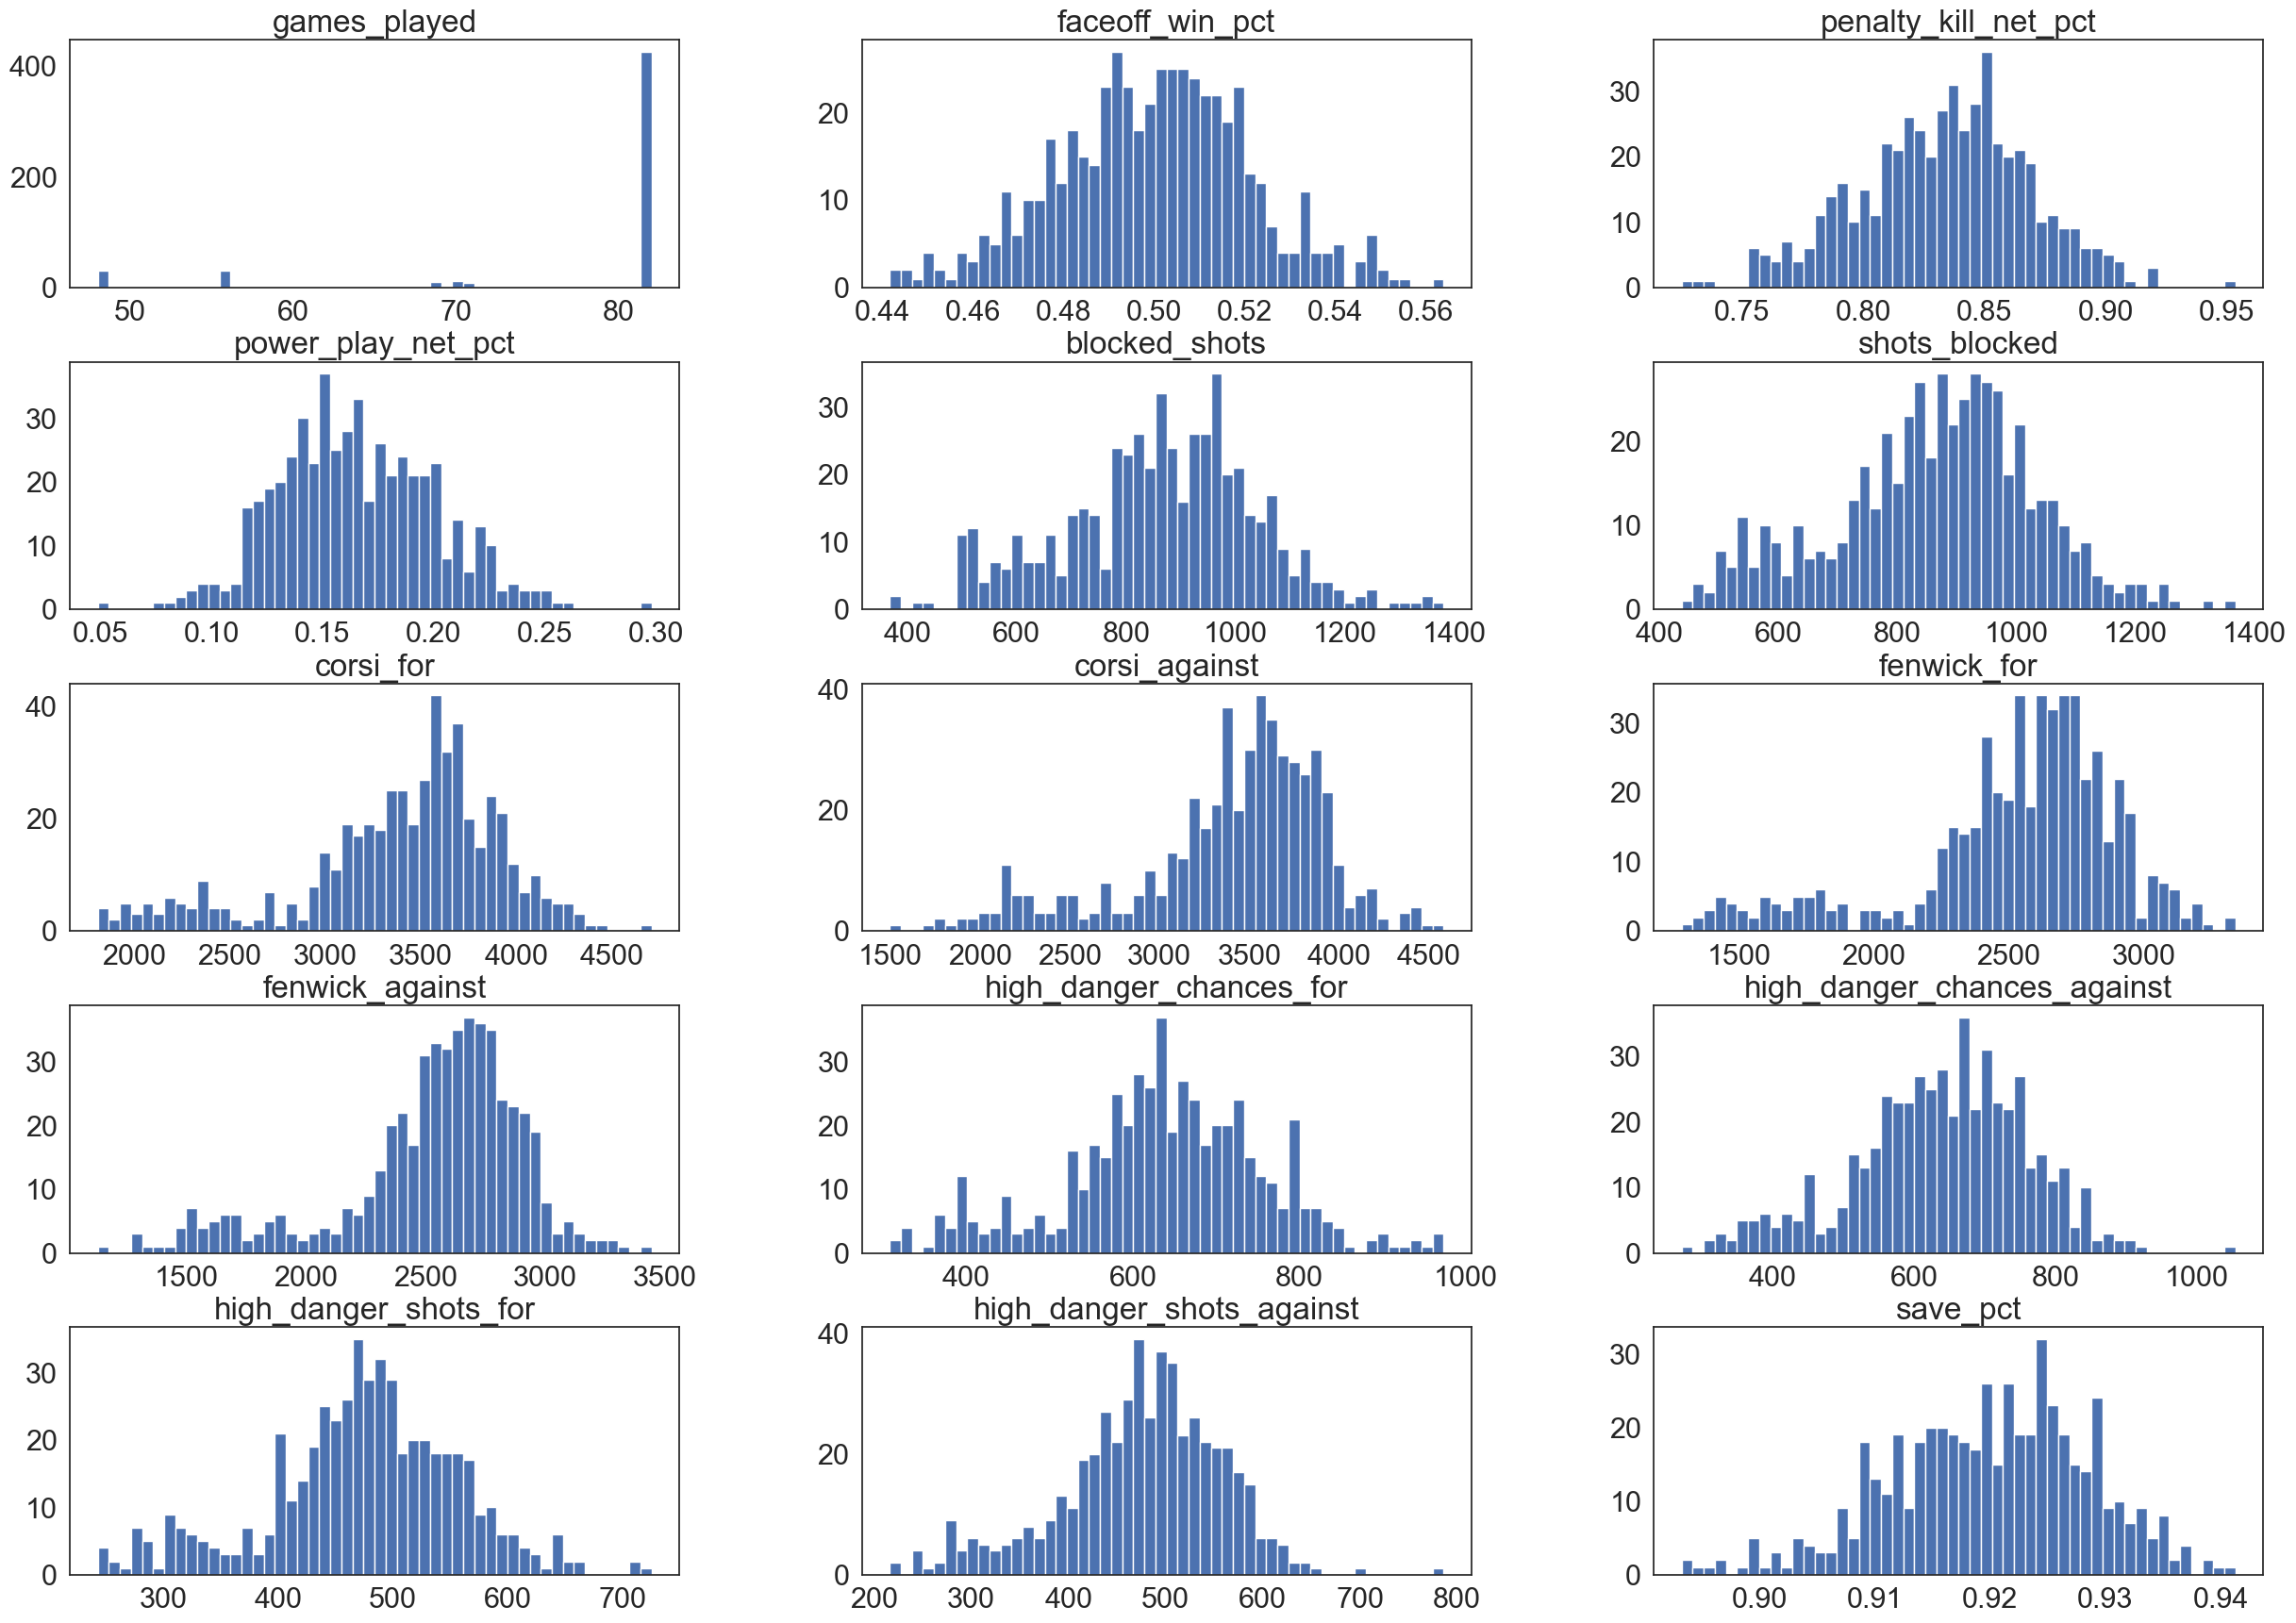


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
games_played,518.0,77.745174,9.921585,48.000000,82.000000,82.000000,82.000000,82.000000
faceoff_win_pct,518.0,0.499795,0.021306,0.441552,0.485880,0.500841,0.513613,0.563949
penalty_kill_net_pct,518.0,0.833476,0.035138,0.725000,0.811199,0.836182,0.856548,0.953667
power_play_net_pct,518.0,0.165413,0.035044,0.048780,0.141439,0.163183,0.189455,0.298181
blocked_shots,518.0,863.658301,176.164490,368.000000,757.500000,873.000000,976.000000,1380.000000
shots_blocked,518.0,863.540541,168.195133,438.000000,763.250000,880.000000,969.750000,1368.000000
corsi_for,518.0,3390.001931,542.168907,1808.000000,3155.750000,3506.000000,3726.750000,4709.000000
corsi_against,518.0,3390.774131,543.854171,1496.000000,3177.750000,3506.500000,3757.000000,4583.000000
fenwick_for,518.0,2526.461390,390.727979,1288.000000,2392.000000,2611.000000,2768.750000,3341.000000
fenwick_against,518.0,2527.115830,392.057280,1128.000000,2389.750000,2609.500000,2777.750000,3444.000000


In [72]:
columns_to_float = df.columns[3:]

for col in columns_to_float:
    df[col] = df[col].astype(float)
    
columns_to_object = df.columns[0:3]
    
for col in columns_to_object:
    df[col] = df[col].astype(object)

# Distributions of numeric continuous perdictor variables
Preprocessing.num_univariate_histogram(
    df=df, 
    length=30, 
    width=30, 
    rows=7, 
    col=3,
    font=2
)

### Comments on Feature Distributions and Selection

#### Observations on Games Played
- **Deviations in Games Played**:
  - The distribution of games played shows two smaller deviations from the "norm," which can be attributed to:
    1. The **2012/2013 NHL lockout**, which shortened the season.
    3. The **2020/2021 start of COVID-19 pandemic**, which shortened the season.
    3. The **2020/2021 COVID-19 pandemic**, which also resulted in a reduced number of games.
  - Despite these deviations, the central tendency of the data remains intact, and corresponding metrics (as well as the target variable, **wins**) remain aligned. As a result, **there is no need to normalize these features**.

---

### Key Takeaway
despite the deviations caused by shortened seasons, the distributions appear to be normally disributed and carefully excluding redundant or irrelevant features (e.g., overtime/shootouts and win/loss metrics), the analysis ensures that the model remains robust and unbiased, focusing only on features that provide meaningful predictive power that are relavent to the target audience.


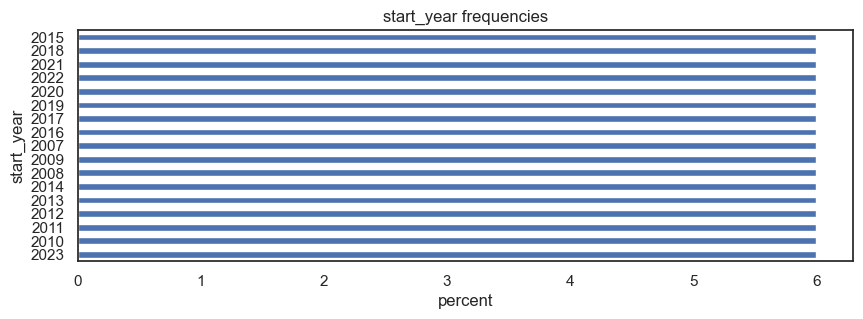

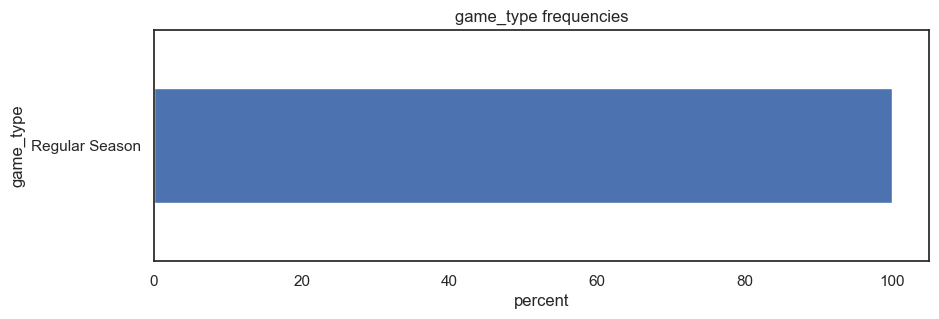

,count,unique
wins,518,42
start_year,518,17
game_type,518,1


In [73]:
# View frequencies of categorical data
Preprocessing.cat_univariate_freq(
    df=df, 
    length=3, 
    width=10, 
    col_start=1, 
    col_end=3, 
    font=1
)


describe = df.describe(include=object)
describe = describe.T
describe = describe.drop(
    ['top', 'freq'], 
    axis=1, 
    errors='ignore'
)

describe

### Comments on Feature frequencies and Selection

#### Observations on Feature Exclusion
- **Categorical And Binary Features in Focus**:
  - These features are excluded from the analysis as they are mainly used in this analysis and anlyses to come as dimentions to futher slice the data as we did with Regular Season (excluding playoffs as plaoffs is a seprate season and analysis).

---

### Key Takeaway
By restricting the analysis to regular season data and excluding playoff-related features, the model remains aligned with the intended scope, ensuring that the results are focused and interpretable within the context of regular season performance. Additionally, because all frequencies for start years are the same, it is evident that the number of teams in the measured seasons is equal across all seasons.

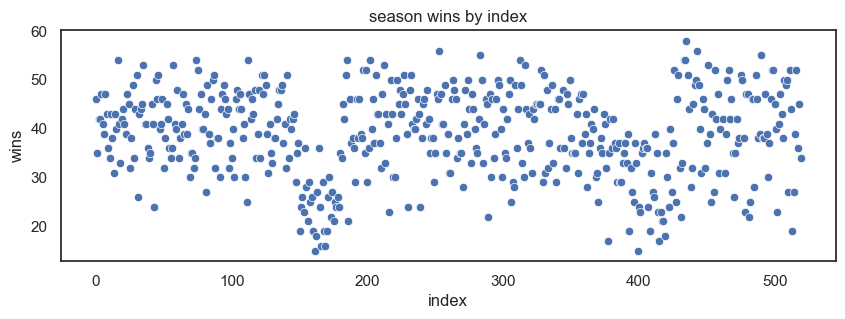

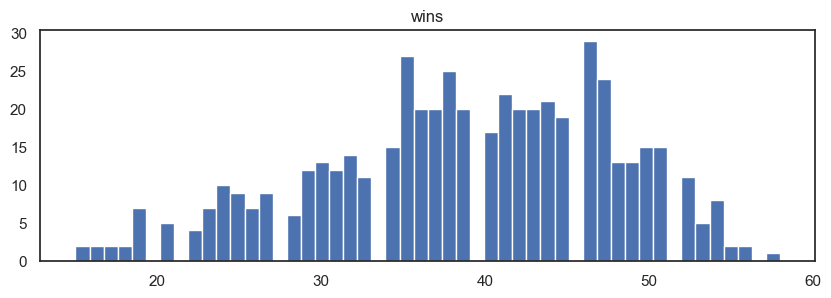


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
wins,518.0,38.785714,8.906045,15.0,33.0,39.0,46.0,58.0



normality test:

statistic: 0.0
p-value: 19.4



In [74]:
Preprocessing.target_univariate_scatter(
    df=df, 
    x='index', 
    y='wins', 
    length=3, 
    width=10, 
    font=1
)

y_hist = df[['wins']]
y_hist['wins'] = y_hist['wins'].astype(int)

Preprocessing.num_univariate_histogram(
    df=y_hist,
    length=3, 
    width=10,
    rows=1, 
    col=1, 
    font=1
)

print(
    "\n"
    + "normality test:"
    + "\n"
    + "\n"
    + "statistic: "
    + str(round(normaltest(y_hist["wins"].values)[1], 2))
    + "\n"
    + "p-value: "
    + str(round(normaltest(y_hist["wins"].values)[0], 2))
    + "\n"
)


### Exploration on the Target Variable: Wins

#### Observations from the Scatter Plot (Wins by Index)
1. **Random Distribution**:
   - The scatter plot shows that the target variable, **wins**, is randomly distributed across the dataset index, though there are observable patterns or trends, this is because of the lockout and the COVID pandemic season (shortened). This is why we can observe dips in the scatter plot across the data's index.
   - This randomness indicates that the target variable is not influenced by the order of the data, reducing the risk of systematic bias.

2. **Range of Wins**:
   - The number of wins spans a wide range, approximately between **15 and 58**, showcasing variability across teams or seasons.

---

#### Observations from the Histogram (Wins)
1. **Central Tendency**:
   - The histogram of **wins** exhibits a normal distribution, with most values concentrated around the mean (approximately **39 wins**).
   - The interquartile range (IQR) indicates that 50% of the data falls between **33 and 46 wins**, suggesting that most teams achieve this range of performance.

2. **Skewness and Outliers**:
   - The distribution is slightly skewed to the left, with fewer instances of teams achieving very high or very low win totals.
   - A small number of outliers are visible on the higher end (teams with **60+ wins**), which could represent exceptional team performances in specific seasons.

---

#### Descriptive Statistics
- **Mean and Median**:
  - The mean of **38.88 wins** is close to the median (**39 wins**), indicating a balanced dataset with no extreme skewness.
- **Standard Deviation**:
  - A standard deviation of **9.02** reflects moderate variability in team performance.
- **Min and Max**:
  - The minimum win total is **15**, while the maximum is **65**, showing a significant range in performance across teams and seasons.

---

#### Normality Test
- **Test Statistic and P-Value**:
  - The normality test yields a **p-value of 19.4**, which is much higher than the threshold of 0.05, indicating that the distribution of wins does not significantly deviate from normality.
  - This supports the assumption that the target variable is suitable for linear regression modeling.

---

### Key Takeaway
The EDA reveals that **wins** is well-distributed, approximately normal, and free from systematic biases related to data order. While the data includes some outliers at the high end, the majority of teams fall within a predictable range of 33–46 wins. These insights confirm that **wins** is an appropriate target variable for modeling, with minimal preprocessing required.


## Bivariate Analysis

---

In [75]:
# Feature relationship comparison with wins via scatter plots
df['wins'] = df['wins'].astype('int64')
x_num = df.select_dtypes(include=['int64','float64'])
x_num = x_num.drop(['games_played'], axis=1, errors='ignore')

corr = x_num.corr()
corr.style.background_gradient(cmap='coolwarm')

,wins,faceoff_win_pct,penalty_kill_net_pct,power_play_net_pct,blocked_shots,shots_blocked,corsi_for,corsi_against,fenwick_for,fenwick_against,high_danger_chances_for,high_danger_chances_against,high_danger_shots_for,high_danger_shots_against,save_pct
wins,1.000000,0.222783,0.384983,0.423520,0.234530,0.490620,0.607576,0.261985,0.631869,0.258039,0.553465,0.189243,0.584699,0.217490,0.389441
faceoff_win_pct,0.222783,1.000000,0.177689,0.180910,-0.124641,0.130635,0.153432,-0.138884,0.156667,-0.136652,0.094623,-0.173040,0.086303,-0.165237,0.108650
penalty_kill_net_pct,0.384983,0.177689,1.000000,0.095840,-0.157378,0.003298,0.043314,-0.199022,0.058682,-0.205364,0.040426,-0.240936,0.065582,-0.207571,0.248790
power_play_net_pct,0.423520,0.180910,0.095840,1.000000,-0.030709,0.124111,0.133174,-0.056962,0.131364,-0.065219,0.171931,-0.052579,0.145843,-0.076442,0.117566
blocked_shots,0.234530,-0.124641,-0.157378,-0.030709,1.000000,0.694865,0.639378,0.903384,0.588076,0.803822,0.610050,0.748457,0.546819,0.653460,-0.082918
shots_blocked,0.490620,0.130635,0.003298,0.124111,0.694865,1.000000,0.929751,0.690218,0.859644,0.645231,0.780658,0.628062,0.687613,0.553426,-0.032232
corsi_for,0.607576,0.153432,0.043314,0.133174,0.639378,0.929751,1.000000,0.718386,0.987360,0.709237,0.861011,0.655964,0.815841,0.626844,-0.005706
corsi_against,0.261985,-0.138884,-0.199022,-0.056962,0.903384,0.690218,0.718386,1.000000,0.699707,0.981260,0.655260,0.879936,0.620737,0.833665,-0.047739
fenwick_for,0.631869,0.156667,0.058682,0.131364,0.588076,0.859644,0.987360,0.699707,1.000000,0.706378,0.858681,0.639848,0.836056,0.631569,0.005958
fenwick_against,0.258039,-0.136652,-0.205364,-0.065219,0.803822,0.645231,0.709237,0.981260,0.706378,1.000000,0.634848,0.884323,0.615370,0.862822,-0.028965


The pairwise plot above illustrates the bivariate analysis by displaying correlations between all feature pairs. Notably, some features exhibit strong correlations with one another. Based on the Variance Inflation Factor (VIF) test, highly correlated features will be removed from the analysis to mitigate multicollinearity.

Additionally, we can visualize these relationships through a heatmap and a data frame.